In [20]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:

date_cols = [2, 19, 20, 26, 29, 30]
injuries = pd.read_csv('data/injuries_cleaned.csv', parse_dates=date_cols)


In [3]:
injuries.shape

(6540, 46)

In [4]:
bool_variables = ['surgery', 'sprain', 'broken', 'bruise', 'strain']
cat_features = ['GroupPosition', 'main_body_part']
numeric_features = ['Height', 'Weight', 'age_at_injury']
features = np.concat((bool_variables, cat_features, numeric_features))
features

array(['surgery', 'sprain', 'broken', 'bruise', 'strain', 'GroupPosition',
       'main_body_part', 'Height', 'Weight', 'age_at_injury'],
      dtype='<U14')

In [5]:
X = injuries[features] 
y = injuries['log_days_injured']
X_dummies = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, random_state=123)

        

In [6]:
X_train.head()



,surgery,sprain,broken,bruise,strain,Height,Weight,age_at_injury,GroupPosition_C,GroupPosition_F,...,main_body_part_foot,main_body_part_hand,main_body_part_head,main_body_part_heel,main_body_part_hip,main_body_part_knee,main_body_part_leg,main_body_part_neck,main_body_part_shoulder,main_body_part_unknown
4041,False,False,False,True,False,75.0,227.0,7930,False,False,...,False,False,False,False,False,True,False,False,False,False
1635,False,False,False,False,False,84.0,240.0,11111,True,False,...,False,False,False,False,False,False,False,False,False,False
1588,False,False,False,False,False,78.0,195.0,9722,False,True,...,False,False,False,False,False,False,False,False,False,False
2413,False,True,False,False,False,81.0,235.0,10201,False,True,...,True,False,False,False,False,False,False,False,False,False
2948,False,False,False,False,False,75.0,190.0,7967,False,False,...,False,True,False,False,False,False,False,False,False,False


## Linear Regression

In [7]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [8]:
coef = linear_model.coef_
coefs_df = pd.DataFrame({'feature': X_train.columns, 'coef': abs(coef), 'is_pos': coef > 0})


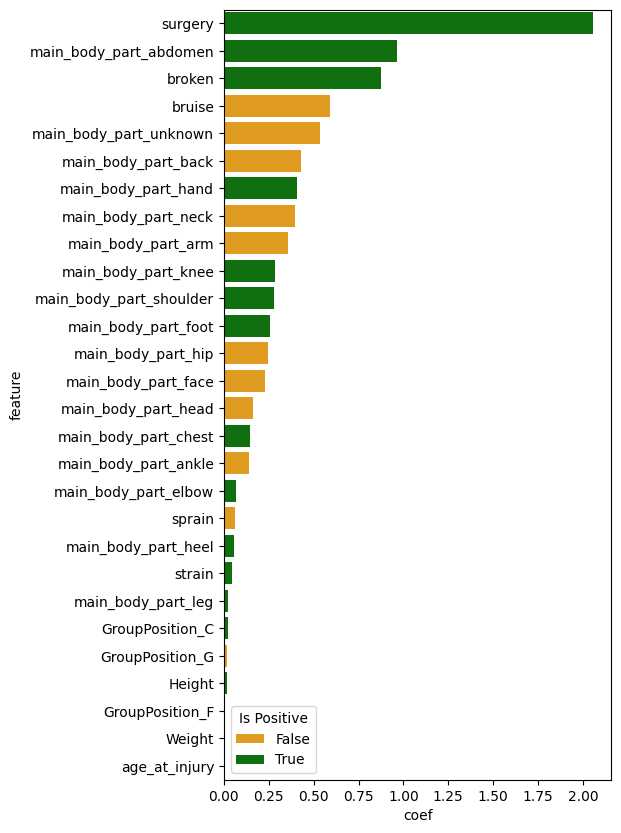

In [9]:
order = coefs_df.sort_values(by='coef', ascending=False)['feature']
plt.figure(figsize=(5, 10))
sns.barplot(coefs_df, x='coef', y='feature', hue='is_pos', palette=['orange', 'green'], order=order)
plt.legend(title='Is Positive')
plt.show()



## Random Forest Model

In [10]:
# n_estimators=[250, 300, 350, 400, 450]
# max_depth=[None, 5, 7, 9, 11]
n_estimators=[350, 400]
max_depth=[7, 9]
grid = GridSearchCV(RandomForestRegressor(), {'n_estimators':n_estimators, 'max_depth':max_depth}, 
                    scoring='neg_mean_absolute_error', cv=5)
grid.fit(X_dummies, y)



GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [7, 9], 'n_estimators': [350, 400]},
             scoring='neg_mean_absolute_error')

In [16]:
tree_model = RandomForestRegressor(max_depth=9, n_estimators=400)
tree_model.fit(X_train, y_train)
importances = tree_model.feature_importances_
importance_df = pd.DataFrame({'feature': X_test.columns, 'importance': importances})


<Axes: xlabel='importance', ylabel='feature'>

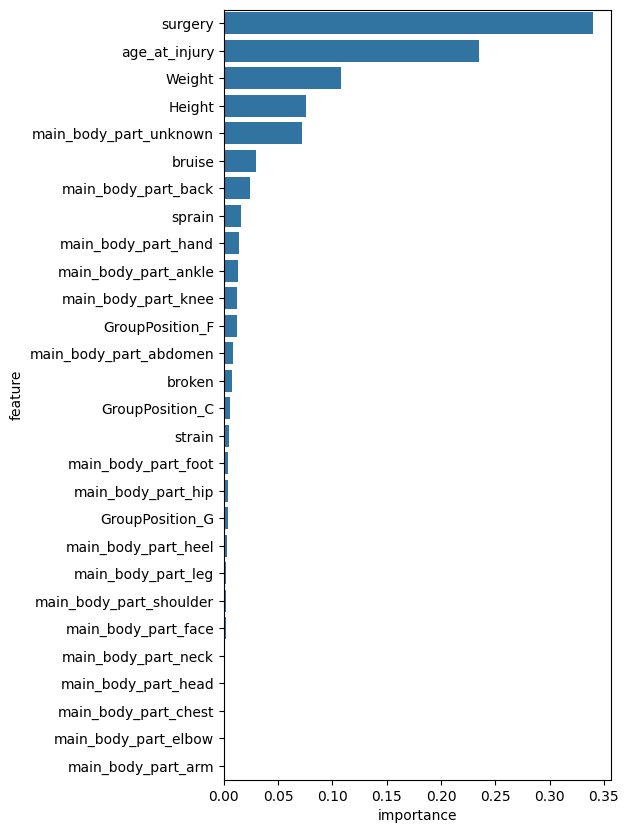

In [17]:
order = importance_df.sort_values(by='importance', ascending=False)['feature']
plt.figure(figsize=(5, 10))
sns.barplot(x=importance_df['importance'], y=importance_df['feature'], order=order)


In [18]:

tree_pred = tree_model.predict(X_test) 
linear_pred = linear_model.predict(X_test)


In [19]:
print('Linear MAE', mean_absolute_error(y_test, linear_pred))
print('Tree MAE', mean_absolute_error(y_test, tree_pred))
print('null MAE', (abs(y_test - y_train.mean())).mean())

Linear MAE 1.271641514436818
Tree MAE 1.2741786844739729
null MAE 1.428985601696409


## Save Model

In [21]:
chosen_model = linear_model
file_name = 'our_model' 
pickle.dump(chosen_model, open(file_name, 'wb'))